<h1><center>Physique numérique (PHY-3500) - TP2</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [1]:
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

# Numéro 1

A) *À l’aide des équations (2.1.2) et (2.1.3), démontrez que les matrices de réflexion $\boldsymbol{Q_i}$ sont orthogonales.*

B) *Démontrez l’équation (2.1.5) et que la matrice $\boldsymbol{Q}$ est orthogonale.*

C) *Implémentez la fonction householder_qr qui prend en argument une matrice $\boldsymbol{A}$ et qui retourne les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ obtenues par la méthode de Householder.*

In [2]:
def householder_qr(
    A: NDArray,
    progress: bool = False,
) -> tuple[NDArray, NDArray]:
    """Calcule la décomposition QR d'une matrice par la méthode de Householder.

    Paramètres
    ----------
    A
        Matrice à décomposer.
    progress
        Affiche progressivement la matrice Q si True.

    Retours
    -------
    Q
        Matrice orthogonale Q.
    R
        Matrice triangulaire supérieure R.

    """
    m, n = A.shape

    # Initialise Q en tant que matrice identité
    Q = np.eye(m)

    # Initialise R comme une copie de A avec le type de données float
    R = np.copy(A).astype(float)

    # Exclut la dernière itération car Q n'a pas besoin de modifications
    # supplémentaires
    for j in range(min(m - 1, n)):
        # Calcule du vecteur de réflexion de Householder
        x = R[j:, j]
        e = np.zeros_like(x)
        x_norm = np.linalg.norm(x)
        e[0] = x_norm
        v = np.sign(x[0]) * x_norm * np.eye(len(x))[0] + x
        v /= np.linalg.norm(v)

        # Applique la réflexion de Householder à R
        R[j:, :] -= 2 * np.outer(v, (v @ R[j:, :]))

        # Appliquer la transformation de Householder sur Q
        Q[j:, :] -= 2 * np.outer(v, (v @ Q[j:, :]))

        if progress is True:
            print(f"Matrice R à l'étape {j} :\n{R.round(3)}\n")

            # Vérification de l'orthogonalité de Q
            is_ortho = np.allclose(np.eye(Q.shape[0]), Q @ Q.T)
            print(f"Q est orthogonale à l'étape {j}: {is_ortho}")

            # Vérification de la triangularité supérieure de R
            is_triu = np.allclose(np.triu(R), R)
            print(f"R est triangulaire supérieure à l'étape {j}: {is_triu}\n")

    # Utiliser np.triu pour obtenir la matrice triangulaire supérieure
    R = np.triu(R)
    return Q.T, R

D) *À l’aide d’une matrice de dimension 4 × 3 de votre choix, testez votre fonction householder_qr et comparez les résultats obtenus avec ceux obtenus à l’aide de la fonction* `numpy.linalg.qr`. *Les matrices sont-elles exactement les mêmes ? Si non, est-ce un problème ?*

In [3]:
# Fixer un "seed" pour avoir une séquence de nombres aléatoire et reproductible
np.random.seed(42)

# Tester la fonction householder_qr avec une matrice aléatoire 4 x 3
A = np.random.rand(4, 3)
Q, R = householder_qr(A)
print("\033[1mDécomposition QR de householder_qr :\033[0m")
print(f"Q :\n{Q}\nR :\n{R}")

# Comparaison avec la décomposition QR de numpy
Q_np, R_np = np.linalg.qr(A, mode="complete")
print("\033[1m\nDécomposition QR de numpy.linalg.qr :\033[0m")
print(f"Q :\n{Q_np}\nR :\n{R_np}\n")

# Différence moyenne entre QR de householder_qr et QR de np.linalg.qr
Q_diff = np.abs(Q - Q_np)
R_diff = np.abs(R - R_np)
print("\033[1mDifférence moyenne des coefficients :\033[0m")
print(f"Q : {Q_diff.mean()}\nR : {R_diff.mean()}")

Décomposition QR de householder_qr :
Q :
[[-0.37390264  0.63777869 -0.08901388 -0.66746662]
 [-0.59763955 -0.12681728 -0.72814804  0.31071655]
 [-0.05798475  0.70307946  0.21352505  0.67581366]
 [-0.70686742 -0.28781069  0.64520076  0.03492047]]
R :
[[-1.00170493 -0.51349302 -1.08737614]
 [ 0.          1.18962568  0.59054853]
 [ 0.          0.          0.57539496]
 [ 0.          0.          0.        ]]

Décomposition QR de numpy.linalg.qr :
Q :
[[-0.37390264  0.63777869 -0.08901388 -0.66746662]
 [-0.59763955 -0.12681728 -0.72814804  0.31071655]
 [-0.05798475  0.70307946  0.21352505  0.67581366]
 [-0.70686742 -0.28781069  0.64520076  0.03492047]]
R :
[[-1.00170493 -0.51349302 -1.08737614]
 [ 0.          1.18962568  0.59054853]
 [ 0.          0.          0.57539496]
 [ 0.          0.          0.        ]]

Différence moyenne des coefficients :
Q : 2.0036056147532122e-16
R : 9.251858538542972e-17


Les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ obtenues à partir de la décomposition $QR$ de la fonction householder_qr ne sont pas exactement les mêmes que celles produites par la fonction `numpy.linalg.qr`. Cependant, cela n'est pas nécessairement un problème, car la décomposition $QR$ n'est pas unique. Il existe plusieurs façons de décomposer une matrice en une matrice orthogonale $\boldsymbol{Q}$ et une matrice triangulaire supérieure $\boldsymbol{R}$, et différentes implémentations peuvent utiliser des méthodes différentes pour parvenir à cette décomposition.

Les différences entre les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ peuvent provenir de la manière dont les calculs sont effectués, des algorithmes utilisés et des conventions de signe adoptées. Si NumPy utilise plutôt la méthode de Gram-Schmidt par exemple, alors les résultats seront légèrment différents de ceux que nous avons calculés avec la fonction householder_qr. Cependant, tant que les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ produites par les deux fonctions sont proches ou suffisamment similaires, elles fournissent toutes deux une décomposition $QR$ valide de la matrice d'entrée. Comme la différence absolue entre les deux fonctions est de l'ordre de $10^{-16}$, tant pour $\boldsymbol{Q}$ que pour $\boldsymbol{R}$, il est juste d'affirmer que les résultats sont similaires.

E) *À l’aide de la matrice utilisée en D, illustrez comment la multiplication successive des matrices $\boldsymbol{Q_i}$ triangularise progressivement la matrice $\boldsymbol{A}$. Dans l’élan, assurez-vous que les matrices $\boldsymbol{Q}$ et $\boldsymbol{R}$ obtenues sont bien orthogonale et triangulaire supérieure, respectivement.*

In [4]:
# Affichage de la matrice A
print(f"\033[1mMatrice A :\033[0m\n{A}\n")

# Affichage des matrices Q et R en affichant la progression
Q, R = householder_qr(A, progress=True)

Matrice A :
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]]

Matrice R à l'étape 0 :
[[-1.002 -0.513 -1.087]
 [-0.    -0.481 -0.635]
 [-0.     0.804  0.524]
 [-0.    -0.733  0.034]]

Q est orthogonale à l'étape 0: True
R est triangulaire supérieure à l'étape 0: False

Matrice R à l'étape 1 :
[[-1.002 -0.513 -1.087]
 [ 0.     1.19   0.591]
 [-0.    -0.    -0.066]
 [-0.     0.     0.572]]

Q est orthogonale à l'étape 1: True
R est triangulaire supérieure à l'étape 1: False

Matrice R à l'étape 2 :
[[-1.002 -0.513 -1.087]
 [ 0.     1.19   0.591]
 [-0.     0.     0.575]
 [-0.    -0.     0.   ]]

Q est orthogonale à l'étape 2: True
R est triangulaire supérieure à l'étape 2: True



# Numéro 2

A) *Modifiez votre code de décomposition QR pour qu’il retourne la décomposition QR réduite de la matrice d’entrée lorsque l’argument additionnel reduite=True lui est passé.*

In [5]:
def householder_qr(
    A: NDArray,
    progress: bool = False,
    reduite: bool = False,
) -> tuple[NDArray, NDArray]:
    """Calcule la décomposition QR d'une matrice par la méthode de Householder.

    Paramètres
    ----------
    A
        Matrice à décomposer.
    progress
        Affiche progressivement la matrice Q si True.
    reduite
        Indique si la décomposition QR réduite doit être retournée (par défaut False).

    Retours
    -------
    Q
        Matrice orthogonale Q.
    R
        Matrice triangulaire supérieure R.

    """
    m, n = A.shape

    # Initialise Q en tant que matrice identité
    Q = np.eye(m)

    # Initialise R comme une copie de A avec le type de données float
    R = np.copy(A).astype(float)

    # Exclut la dernière itération car Q n'a pas besoin de modifications
    # supplémentaires
    for j in range(min(m - 1, n)):
        # Calcule du vecteur de réflexion de Householder
        x = R[j:, j]
        e = np.zeros_like(x)
        x_norm = np.linalg.norm(x)
        e[0] = x_norm
        v = np.sign(x[0]) * x_norm * np.eye(len(x))[0] + x
        v /= np.linalg.norm(v)

        # Applique la réflexion de Householder à R
        R[j:, :] -= 2 * np.outer(v, (v @ R[j:, :]))

        # Appliquer la transformation de Householder sur Q
        Q[j:, :] -= 2 * np.outer(v, (v @ Q[j:, :]))

        if progress is True:
            print(f"Matrice R à l'étape {j} :\n{R.round(3)}\n")

            # Vérification de l'orthogonalité de Q
            is_ortho = np.allclose(np.eye(Q.shape[0]), Q @ Q.T)
            print(f"Q est orthogonale à l'étape {j}: {is_ortho}")

            # Vérification de la triangularité supérieure de R
            is_triu = np.allclose(np.triu(R), R)
            print(f"R est triangulaire supérieure à l'étape {j}: {is_triu}\n")

    Q = Q.T

    # Utiliser np.triu pour obtenir la matrice triangulaire supérieure
    R = np.triu(R)

    # Tronquer pour obtenir la décomposition QR réduite
    if reduite is True:
        R = R[:n, :n]
        Q = Q[:, :n]
    return Q, R

B) *Utilisez votre code pour résoudre approximativement l’équation (2.2.4). Vous utiliserez les données fournies dans le fichier bataille_navale_equipeXX.csv où vous remplacerez XX par votre numéro d’équipe dans la boîte de dépôt sur MonPortail.*

In [6]:
datapath = "Data/bataille_navale_equipe04.csv"
xi, yi = np.genfromtxt(datapath, delimiter=",", skip_header=1, unpack=True)
X = np.ones((xi.size, 3))
X[:, 1] = xi
X[:, 2] = xi**2

# Calculer la décomposition QR réduite avec la fonction householder_qr
Q, R = householder_qr(X, reduite=True)

# Transformer yi en B en utilisant Q^T pour avoir une équation Ax = B
B = Q.T @ yi

# Résoudre Xα = Y pour α
alpha_r = np.linalg.solve(R[:R.shape[1]], B[:R.shape[1]])
print(f"Coefficients \u03B1 avec la décomposition QR réduite :\n{alpha_r}\n")

Coefficients α avec la décomposition QR réduite :
[ 2.41719743e+02  1.99814880e+00 -7.91455411e-04]



C) *Tracez les données (cercles noirs) et la solution estimée de la trajectoire (ligne pleine de la couleur de votre choix) donnée par l’équation (2.2.3).*

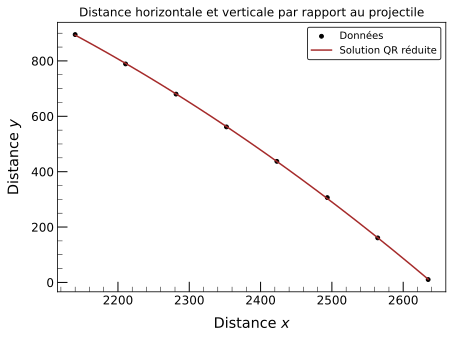

In [7]:
x_gen = np.linspace(xi.min(), xi.max(), 1000)

# Inverser la matrice de coefficients α et utiliser np.polyval
alpha_r = np.flip(alpha_r)

# Calculer la série de puissance y(x) = α_0 + α_1x + α_2x^2
y = np.polyval(alpha_r, x_gen)

plt.scatter(xi, yi, color="k", s=15, label="Données")
plt.plot(x_gen, y, color="brown", label="Solution QR réduite")
plt.title("Distance horizontale et verticale par rapport au projectile")
plt.xlabel("Distance $x$")
plt.ylabel("Distance $y$")
plt.legend()
plt.show()

D) *Obtenez la position d’impact du projectile (à $y = 0$) en résolvant l’équation quadratique (2.2.3) pour $x$ à l’aide d’une implémentation personnelle de la méthode de la bissection. Comparez votre solution avec celle obtenue en résolvant cette même équation analytiquement. Considérant que votre embarcation se situe à la position ($x$, $y$) = (0, 0), quelle est la distance horizontale vous séparant du point d’impact ?*

In [8]:
def bisection(
    coeffs: NDArray,
    a: float,
    b: float,
    tol: float = 1e-8,
    max_n: int = 1000,
) -> float:
    """Calcul la racine d'un polynôme par la méthode de la bissection.

    Paramètres
    ----------
    coeffs
        Les coefficients du polynôme, du terme de plus haut degré
        au terme de plus bas degré.
    a
        La borne inférieure de l'intervalle de recherche.
    b
        La borne supérieure de l'intervalle de recherche.
    tol : optionnel
        La tolérance pour la convergence de la méthode (par défaut 1e-6).
    max_n : optionnel
        Le nombre maximal d'itérations pour la méthode (par défaut 1000).

    Retourne
    --------
    c
        La valeur de la racine du polynôme trouvée dans l'intervalle [a, b].

    Soulève
    -------
    ValueError
        Si les bornes [a, b] ne sont pas valides ou si la méthode ne converge
        pas dans le nombre maximal d'itérations.

    """
    # Définir l'équation quadratique à résoudre
    func = lambda x: np.polyval(coeffs, x)

    # Vérifier si les bornes fournies encadrent une racine
    if func(a) * func(b) >= 0:
        raise ValueError(
            "Les bornes n'encadrent pas une racine ou en encadrent plusieurs."
        )

    # Algorithme de la méthode de la bissection
    for _ in range(max_n):
        # Calcul du point milieu
        c = (a + b) / 2

        # Vérifier si la racine a été trouvée avec une tolérance donnée
        if (b - a) / 2 < tol:
            return c

        # Mettre à jour les bornes selon le signe de la fonction au point milieu
        if func(c) * func(a) < 0:
            b = c
        else:
            a = c

    # Si aucune solution n'a été trouvée dans le nombre maximal d'itérations
    raise ValueError("La méthode de la bissection n'a pas convergé.")


# Calcul de la racine de l'équation quadratique avec la méthode de la bissection
x_impact = bisection(alpha_r, a=2600, b=2700)
print(f"Position d'impact du projectile (à y = 0) : x \u2248 {x_impact}")

Position d'impact du projectile (à y = 0) : x ≈ 2640.323217603145


# Numéro 3

A) *Trouvez analytiquement toutes les solutions de l’équation cubique (2.3.3).*

B) *Démontrez laquelle des solutions obtenues précédemment (ou une combinaison de celles-ci) correspond à $u$, soit la solution recherchée de l’équation (2.3.3).*

C) *Tracez $R_\infty$ en fonction de $T$ et identifiez tout changement qualitatif de $R_\infty$. Comment interprétez-vous ce changement (ou cette absence de changement) ?*

D) *Résolvez numériquement l’équation (2.3.3) à l’aide d’implémentations personnelles de la méthode par relaxation et de la méthode de Newton-Raphson pour 20 valeurs de $T$ uniformément distribuées dans l’intervalle [0, 1]. Illustrez vos résultats à l’aide d’un graphique comparant les solutions analytiques (indiquées avec des lignes de couleurs distinctes) aux solutions numériques obtenues avec différentes valeurs initiales de l’algorithme (symboles ; choisissez bien vos symboles pour que vos solutions soient bien visibles). Arrivez-vous à obtenir les trois solutions identifiées en $\textbf{A}$ ? Pourquoi ? Considérez tracer l’équation (2.3.3) de même que la dérivée de $f(u)$ en fonction de $u$ et ce, pour quelques valeurs de $T$, pour appuyer vos conclusions. Vous pouvez aussi tracer les itérations successives de chacune des méthodes afin d’illustrer la manière dont elles convergent vers l’une ou l’autre des solutions (ex. : tracer un diagramme en toile d’araignée).*